In [1]:
## Setup a program to find the parameters for a action sequence assuming q-learning

# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from joblib import Parallel, delayed
from tqdm import tqdm
import pickle

from models import QLearning, HetQLearning, FQLearning, HetFQLearning

# import data

choices_full = np.loadtxt('data/kaitlyn2023/full_action_set.csv', delimiter=',', dtype=np.float64)
rewards_full = np.loadtxt('data/kaitlyn2023/full_reward_set.csv', delimiter=',',dtype=np.float64)

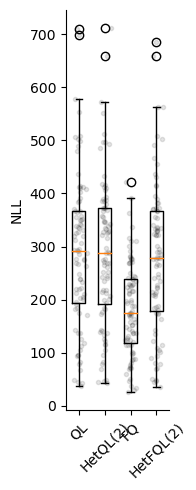

In [13]:
fig, ax = plt.subplots(1,1, figsize=(2,5))

results = pickle.load(open('fitted_models/kaitlyn2023/QL_loocv_shgo.pkl','rb'))
model = QLearning()
train_scores1 = np.array([res.fun for res in results])
test_scores1 = np.array([model.nll(res.x, choices_full[i:i+1], rewards_full[i:i+1]) for i, res in enumerate(results)])
N = len(test_scores1)
plt.plot(0.0*np.ones(N)+0.1*np.random.randn(N),test_scores1,'k.',alpha=0.1)
plt.boxplot(test_scores1, positions=[0.0], widths=0.5)

results = pickle.load(open('fitted_models/kaitlyn2023/Het2QL_loocv_shgo.pkl','rb'))
model = HetQLearning(2)
train_scores2 = np.array([res.fun for res in results])
test_scores2 = np.array([model.nll(res.x, choices_full[i:i+1], rewards_full[i:i+1]) for i, res in enumerate(results)])
N = len(test_scores2)
plt.plot(1.0*np.ones(N)+0.1*np.random.randn(N),test_scores2,'k.',alpha=0.1)
plt.boxplot(test_scores2, positions=[1.0], widths=0.5)

results = pickle.load(open('fitted_models/kaitlyn2023/FQL_loocv_shgo.pkl','rb'))
model = FQLearning()
train_scores3 = np.array([res.fun for res in results])
test_scores3 = np.array([model.nll(res.x, choices_full[i:i+1], rewards_full[i:i+1]) for i, res in enumerate(results)])
N = len(test_scores3)
plt.plot(2.0*np.ones(N)+0.1*np.random.randn(N),test_scores3,'k.',alpha=0.1)
plt.boxplot(test_scores3, positions=[2.0], widths=0.5)

results = pickle.load(open('fitted_models/kaitlyn2023/Het2FQL_loocv_shgo.pkl','rb'))
model = HetFQLearning(2)
train_scores4 = np.array([res.fun for res in results])
test_scores4 = np.array([model.nll(res.x, choices_full[i:i+1], rewards_full[i:i+1]) for i, res in enumerate(results)])
N = len(test_scores4)
plt.plot(3.0*np.ones(N)+0.1*np.random.randn(N),test_scores4,'k.',alpha=0.1)
plt.boxplot(test_scores4, positions=[3.0], widths=0.5)

plt.xticks([0,1,2,3],['QL','HetQL(2)','FQ','HetFQL(2)'], rotation=45)
plt.ylabel('NLL')
# remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.show()

['q0_init', 'q1_init', 'alpha_0', 'kappa_0', 'alpha_1', 'kappa_1', 'tau', 'beta']


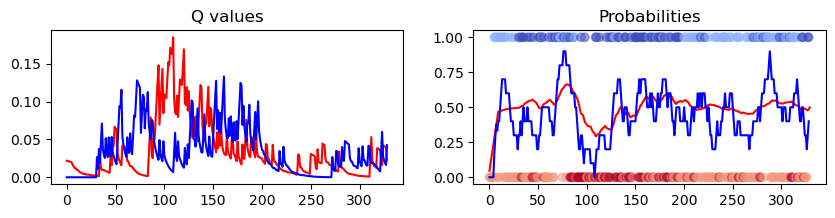

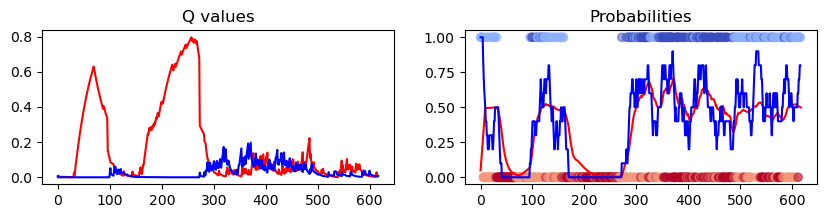

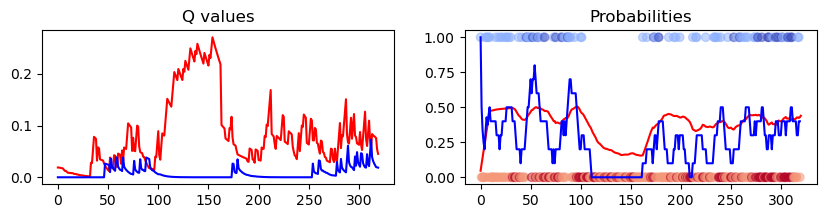

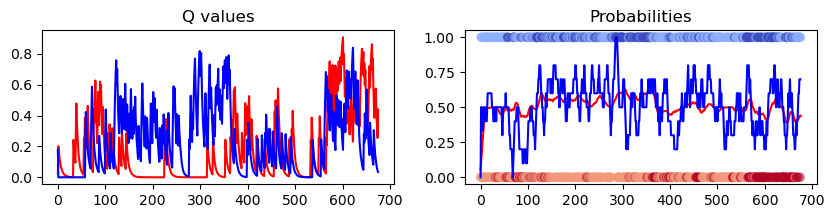

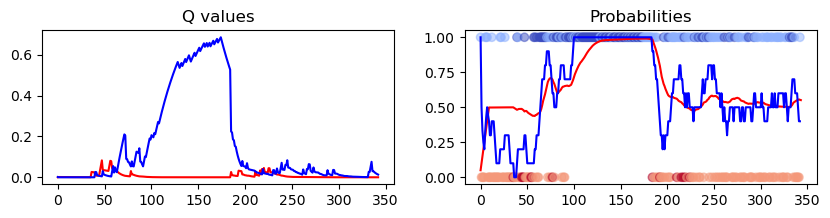

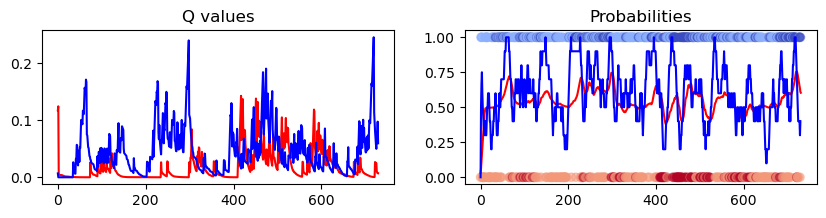

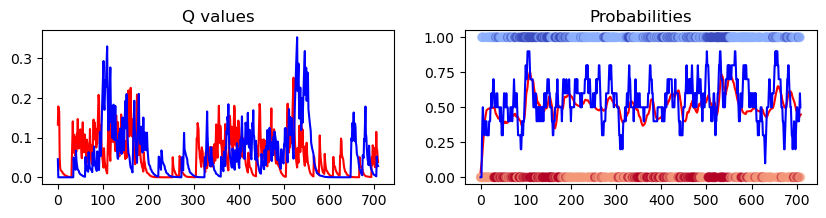

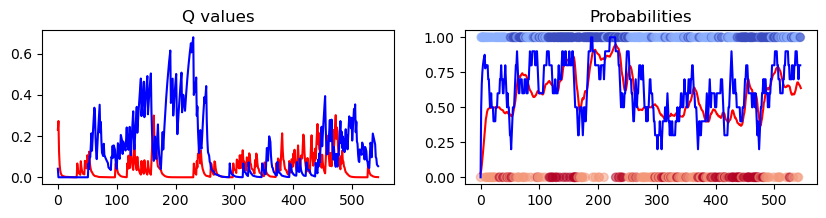

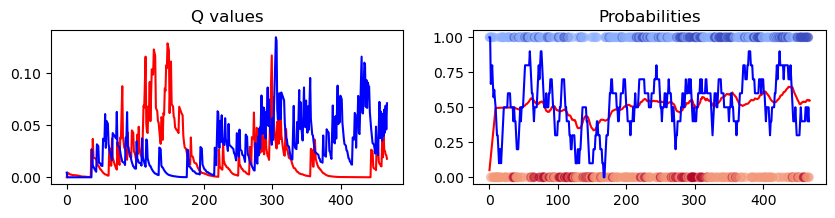

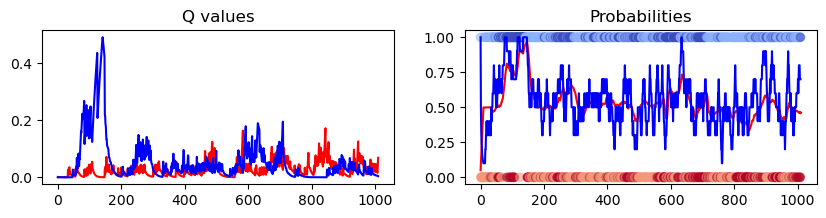

In [19]:
# initialize the class
results = pickle.load(open('fitted_models/kaitlyn2023/Het2FQL_loocv_shgo.pkl','rb'))
qlearn = HetFQLearning(2)
print(qlearn.param_props()['names'])

for i in range(10):
    # plot the results
    if np.any(np.isnan(choices_full[i])):
        cf = choices_full[i][:np.argmax(np.isnan(choices_full[i]))]
    else:
        cf = choices_full[i]
    if np.any(np.isnan(rewards_full[i])):
        rf = rewards_full[i][:np.argmax(np.isnan(rewards_full[i]))]
    else:
        rf = rewards_full[i]

    qs = qlearn.q_learning(cf, rf, results[i].x)
    

    fig,ax = plt.subplots(1,2, figsize=(10,2))
    ax[0].plot(qs[:-1,0], color='red')
    ax[0].plot(qs[:-1,1], color='blue')
    ax[0].set_title('Q values')

    ps = qlearn.prob_choice(cf, rf, results[i].x)
    
    # calculate choice ratio
    cr_est = np.convolve(ps[:,1],np.ones(10)/10,mode='full')[:len(ps[:,1])]
    cr_true = np.convolve(cf,np.ones(10)/10,mode='full')[:len(cf)]/(np.convolve(1-cf,np.ones(10)/10,mode='full')[:len(cf)]+np.convolve(cf,np.ones(10)/10,mode='full')[:len(cf)])

    ax[1].plot(cr_est, color='red')
    ax[1].plot(cr_true, color='blue')
    c=(((rf+1)*(1-2*cf))+2)/4
    ax[1].scatter(np.arange(len(cf)), cf, c=plt.cm.coolwarm(c),alpha=0.5)
    ax[1].set_title('Probabilities')
    plt.show()


In [4]:
# calculate p-value between test scores
import scipy.stats as st

st.ttest_rel(test_scores1,test_scores2)


Ttest_relResult(statistic=18.20355572780543, pvalue=1.0914771570516149e-37)

In [8]:
model = HetQLearning(2)

train_scores = [res.fun for res in results]
test_scores = [model.nll(res.x, choices_full[i:i+1], rewards_full[i:i+1]) for i, res in enumerate(results)]


In [9]:
np.mean(np.array(train_scores)/131) , np.mean(np.array(test_scores))

(94.27299068023748, 94.43707554914434)

In [40]:


## STRUCTURE OF PARAMS
# params = [q0_init, q1_init, qupdate_1, qupdate_2 ... qupdate_n, policy_1, policy_2 ... policy_n]

# import from models.py

class QLearning():

    # initialize the class
    def __init__(self, eps=1e-6):
        self.eps = eps

    # define the q update function
    def q_update(self, q, choice, reward, params):
        params = np.array(params)
        alpha = params[0]
        q[choice] = q[choice] + alpha*(reward - q[choice])
        return q

    # define the q learning function
    def q_learning(self, choices, rewards, params):
        qs = np.zeros((len(choices)+1,2))
        qs[0,:] = params[:2]
        for i in range(len(choices)):
            qs[i+1,:] = self.q_update(qs[i,:],int(choices[i]), rewards[i], params[2:])
        return qs

    # define the policy function
    def policy(self,q,params):
        p = np.exp(np.clip(q/params[-1],-100,100))
        p = p / np.sum(p, axis=1)[:,None]
        return p

    # define parameter names
    def param_props(self):
        param_props = {
            'names': ['q0_init', 'q1_init', 'alpha', 'beta'],
            'suggested_bounds': [(0,1),(0,1),(0,1),(0.01,100)],
            'suggested_init': [0.5,0.5,0.5,1.],
            'n_q': 1, # number of q update parameters
            'n_p': 1 # number of policy parameters
            }
        return param_props
    
    # calculate the probability of choosing each action based on history
    def prob_choice(self, choices, rewards, params):
        qs = self.q_learning(choices, rewards, params)
        ps = np.clip(self.policy(qs,params), self.eps, 1-self.eps)
        return ps
    
    # define the regularizer
    def regularizer(self, params):
        return 0

    # calculate the negative log likelihood
    def nll(self, params, choices, rewards):
        lls = []
        for i in range(len(choices)):
            ps = self.prob_choice(choices[i], rewards[i], params)[:-1,:]
            lls.append(np.sum(choices[i] * np.log(ps[:,1]) + (1-choices[i]) * np.log(ps[:,0])))
        return -np.sum(lls)
    
    # calculate the regularized negative log likelihood
    def nll_reg(self, params, choices, rewards, lambda_reg):
        return self.nll(params, choices, rewards) + self.regularizer(params) * lambda_reg
    
    # fit the model to all subjects
    def fit_all(self, choices, rewards, params_init, lambda_reg=0, **kwargs):
        res = opt.shgo(
            self.nll_reg,
            args=(choices, rewards, lambda_reg),**kwargs)
        return res
    
    # define a function to fit the model to a single subject
    def fit_subject(self, subject, choices, rewards, params_init, lambda_reg=0, **kwargs):
        res = self.fit_all(
            choices[subject:subject+1], rewards[subject:subject+1], params_init, **kwargs
            )
        return res

    # define a function to fit the model to all subjects except one
    def fit_all_except(self, subject, choices, rewards, params_init, lambda_reg=0, **kwargs):
        res = self.fit_all(
            np.concatenate((choices[:subject],choices[subject+1:])),
            np.concatenate((rewards[:subject],rewards[subject+1:])),
            params_init, **kwargs
            )
        return res
    
class HetQLearning(QLearning):

    # redefine the init function
    def __init__(self, N_modules=2, eps=1e-6):
        self.N_modules = N_modules
        self.eps = eps

    # redefine the parameter properties
    def param_props(self):
        param_props = {
            'names': ['q0_init', 'q1_init'] + ['alpha_%i' % i for i in range(self.N_modules)] + ['tau', 'beta'],
            'suggested_bounds': [(0,1),(0,1)] + [(0,1) for i in range(self.N_modules)] + [(1,30), (0.01,100)],
            'suggested_init': [0.5,0.5] + (np.arange(1,self.N_modules+1)/(self.N_modules+1)).tolist() + [7.,1.],
            'n_q': 1, # number of q update parameters per module
            'n_p': 2 # number of policy parameters
            }
        return param_props

    # redefine the q learning function
    def q_learning(self, choices, rewards, params):
        # define two sets of q values
        qs = np.zeros((len(choices)+1,2,self.N_modules))
        qs[:,0,:] = params[:2]
        n_q = self.param_props()['n_q']
        for i in range(len(choices)):
            for j in range(self.N_modules):
                qs[i+1,:,j] = self.q_update(qs[i,:,j],int(choices[i]), rewards[i], params[2+j*n_q:])
        # find likelihood of each set of q values
        ps = np.clip(self.policy(qs,params), self.eps, 1-self.eps)[:-1,:,:]
        ll = choices[:,None] * np.log(ps[:,1,:]) + (1-choices[:,None]) * np.log(ps[:,0,:])
        # define the tau exponential kernel
        tau = params[-2]
        kernel = np.exp(np.arange(len(choices))/ tau)
        cutoff_idx = np.where(kernel < 0.1)[0][0] if len(np.where(kernel < 0.1)[0]) > 0 else len(kernel)
        kernel = kernel[:cutoff_idx][::-1]
        kernel = kernel / np.sum(kernel)
        # apply the kernel convolution along the choice dimension
        ll = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='full'), 0, ll)[:len(choices),:]
        # apply the softmax
        w = np.exp(ll)
        w = w / np.sum(w, axis=1)[:,None]
        # calculate the weighted average of the q values
        out = np.zeros_like(qs[:-1,:,0])
        for i in range(self.N_modules):
            out += qs[:-1,:,i] * w[:,i][:,None]
        # append the first set of q values
        out = np.concatenate((qs.mean(axis=1)[0,:][None,:], out), axis=0)
        return out

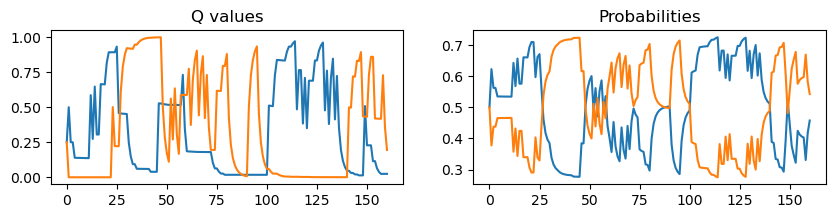

Splitting first generation
Starting minimization at [ 0.5    0.5    0.5    0.5   15.5   50.005]...
bounds in kwarg:
[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [1.0, 30.0], [0.01, 100.0]]


/groups/turner/home/mohantas/anaconda3/envs/flymazerl/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


lres =      fun: 12771.006721876034
     jac: array([2264.3996582 ,  614.0892334 , 2159.54016113,   31.9465332 ,
          5.5423584 ,  -16.64135742])
 message: 'Optimization terminated successfully'
    nfev: 198
     nit: 28
    njev: 24
  status: 0
 success: True
       x: array([5.02956903e-04, 1.37956703e-01, 1.07178690e-02, 1.26701493e-01,
       7.92608508e+00, 2.31434977e-01])
Successfully completed construction of complex.


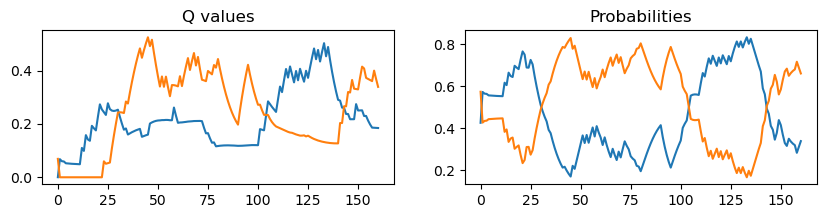

In [44]:
# initialize the class
qlearn = HetQLearning(2)
print(qlearn.param_props()['names'])

# define a guess for the parameters
params_bounds = qlearn.param_props()['suggested_bounds']
params_init = qlearn.param_props()['suggested_init']

qs = qlearn.q_learning(choices_full[0], rewards_full[0], params_init)
ps = qlearn.prob_choice(choices_full[0], rewards_full[0], params_init)

fig,ax = plt.subplots(1,2, figsize=(10,2))
ax[0].plot(qs)
ax[0].set_title('Q values')
ax[1].plot(ps)
ax[1].set_title('Probabilities')
plt.show()


# fit the model to the data using SHGO
res = qlearn.fit_all(
    choices_full, rewards_full, params_init, lambda_reg=0,
    bounds=params_bounds,options={'disp':True})

# plot the results
qs = qlearn.q_learning(choices_full[0], rewards_full[0], res.x)
ps = qlearn.prob_choice(choices_full[0], rewards_full[0], res.x)

fig,ax = plt.subplots(1,2, figsize=(10,2))
ax[0].plot(qs)
ax[0].set_title('Q values')
ax[1].plot(ps)
ax[1].set_title('Probabilities')
plt.show()


In [45]:
print("Best fit parameters: ")
for i,j in zip(qlearn.param_props()['names'], res.x):
    print(i, j)

Best fit parameters: 
q0_init 0.0005029569033449624
q1_init 0.13795670309401323
alpha_0 0.010717869036489342
alpha_1 0.12670149326173505
tau 7.926085084105921
beta 0.2314349766334489


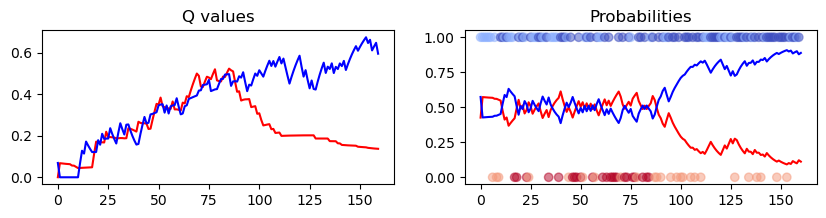

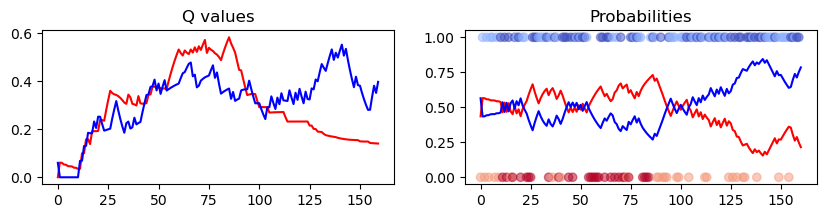

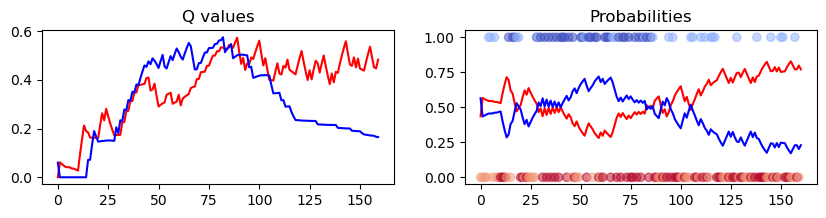

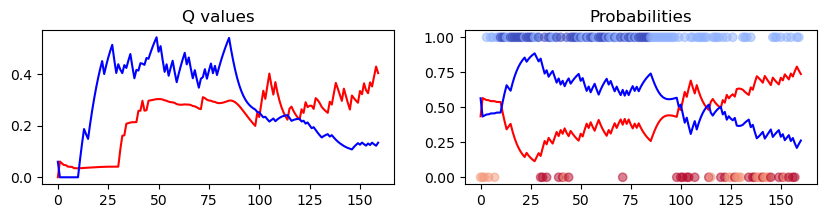

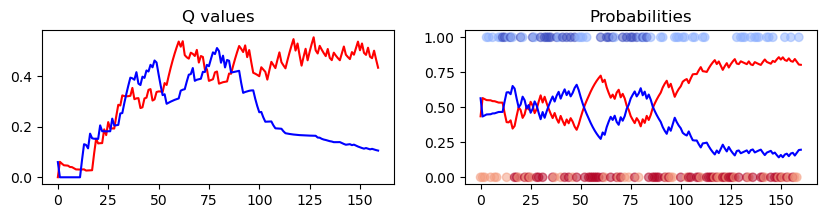

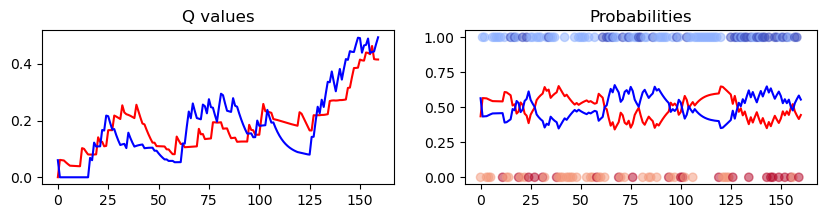

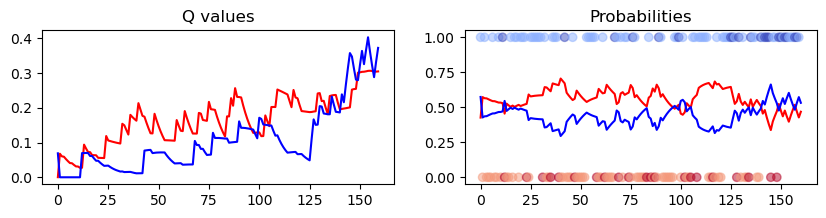

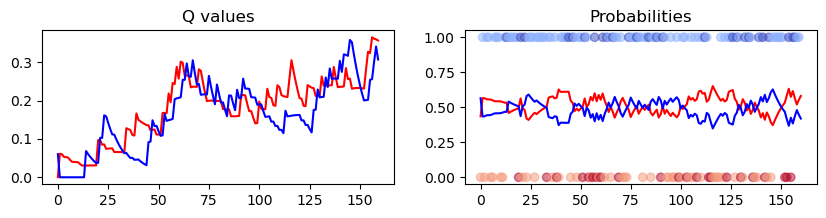

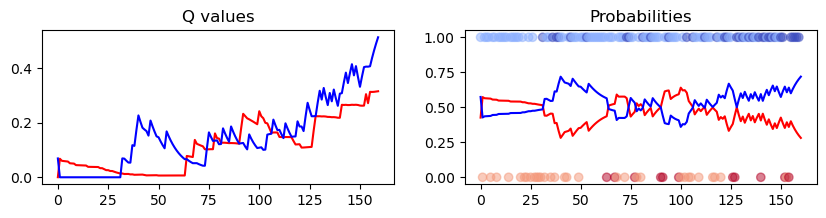

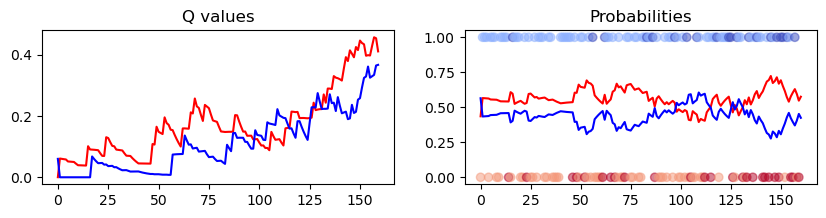

In [46]:
for i in range(10,20):
    # plot the results
    qs = qlearn.q_learning(choices_full[i], rewards_full[i], res.x)
    ps = qlearn.prob_choice(choices_full[i], rewards_full[i], res.x)

    fig,ax = plt.subplots(1,2, figsize=(10,2))
    ax[0].plot(qs[:-1,0], color='red')
    ax[0].plot(qs[:-1,1], color='blue')
    ax[0].set_title('Q values')
    ax[1].plot(ps[:,0], color='red')
    ax[1].plot(ps[:,1], color='blue')
    c=(((rewards_full[i]+1)*(1-2*choices_full[i]))+2)/4
    ax[1].scatter(np.arange(len(choices_full[i])), choices_full[i], c=plt.cm.coolwarm(c),alpha=0.5)
    ax[1].set_title('Probabilities')
    plt.show()

In [ ]:
print("Best fit parameters: ")
for i,j in zip(qlearn.param_props()['names'], res.x):
    print(i, j)

Best fit parameters: 
q0_init 5.881702172083938e-05
q1_init 0.5543438842062629
alpha_0 0.06510713752667475
alpha_1 0.5059135264252279
tau 13.78371466073756
beta 0.995666684983487


In [13]:
qlearn.nll(res.x, choices_full[10:], rewards_full[10:])

11662.84269812533

In [ ]:
print("Best fit parameters: ")
for i,j in zip(qlearn.param_names(), res.x):
    print(i, j)

Best fit parameters: 
q0_init 0.8141194457420927
q1_init 0.8332592710807964
alpha 0.12680998094782234
kappa 1.0
beta 0.01


In [ ]:
qlearn.nll(res.x, choices_full[10:], rewards_full[10:])

4326.424714296936

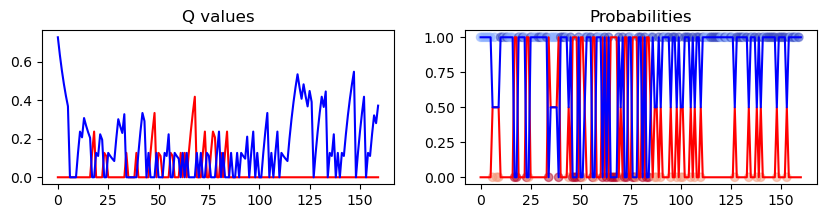

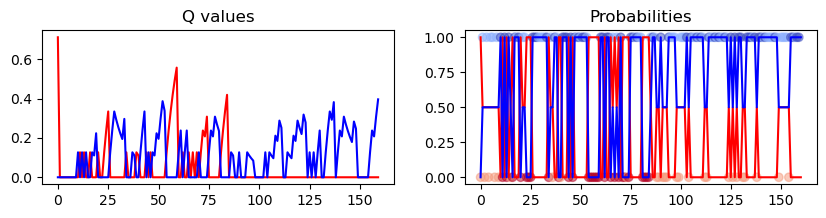

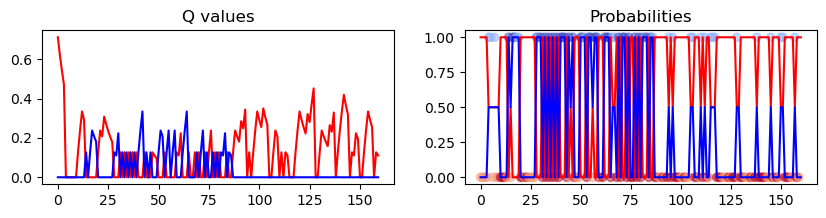

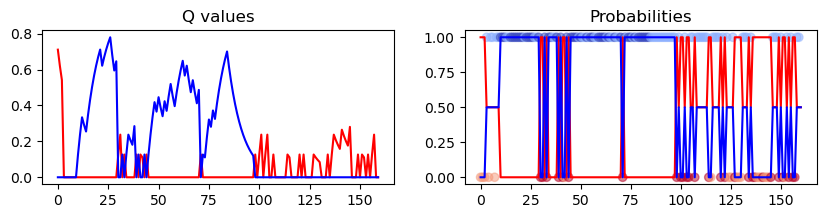

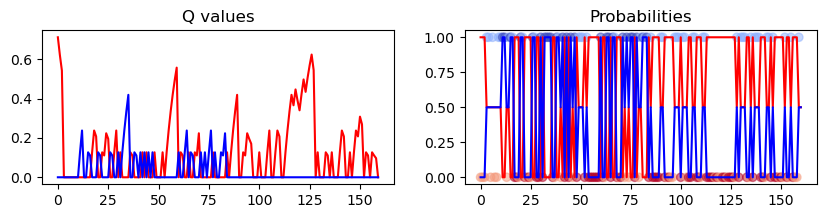

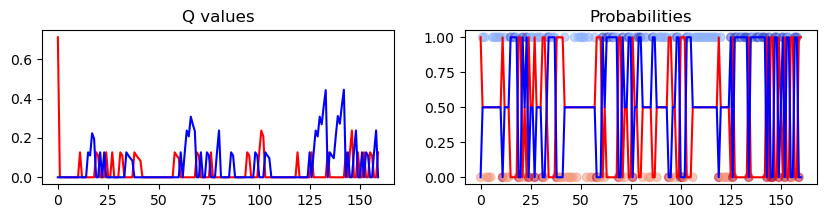

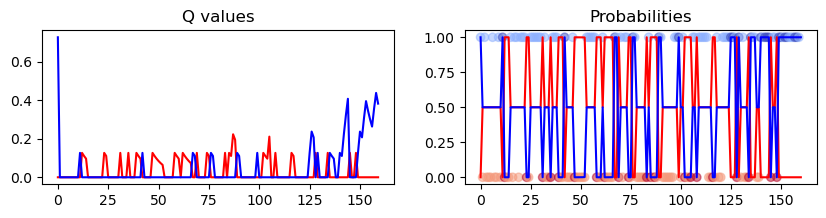

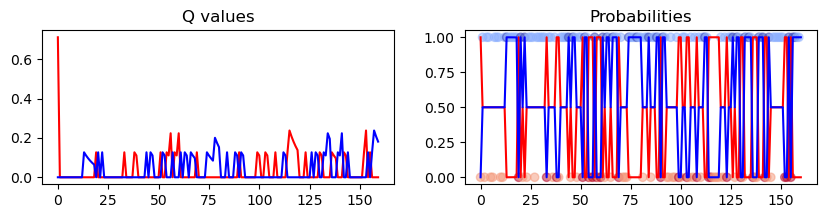

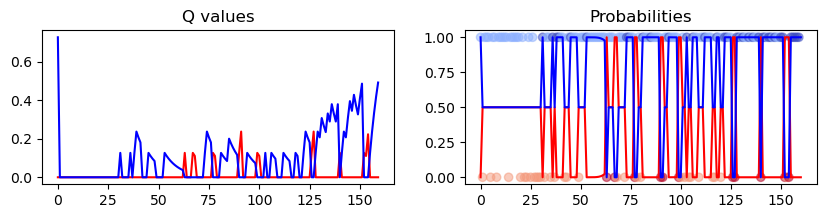

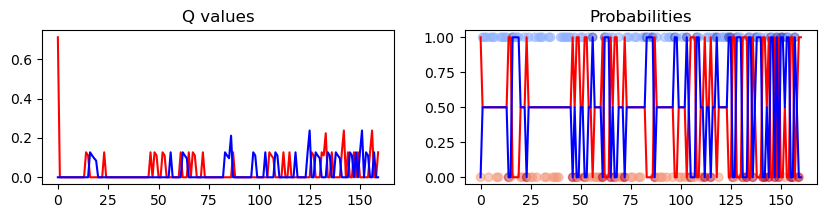

In [7]:
for i in range(10,20):
    # plot the results
    qs = qlearn.q_learning(choices_full[i], rewards_full[i], res.x)
    ps = qlearn.prob_choice(choices_full[i], rewards_full[i], res.x)

    fig,ax = plt.subplots(1,2, figsize=(10,2))
    ax[0].plot(qs[:-1,0], color='red')
    ax[0].plot(qs[:-1,1], color='blue')
    ax[0].set_title('Q values')
    ax[1].plot(ps[:,0], color='red')
    ax[1].plot(ps[:,1], color='blue')
    c=(((rewards_full[i]+1)*(1-2*choices_full[i]))+2)/4
    ax[1].scatter(np.arange(len(choices_full[i])), choices_full[i], c=plt.cm.coolwarm(c),alpha=0.5)
    ax[1].set_title('Probabilities')
    plt.show()

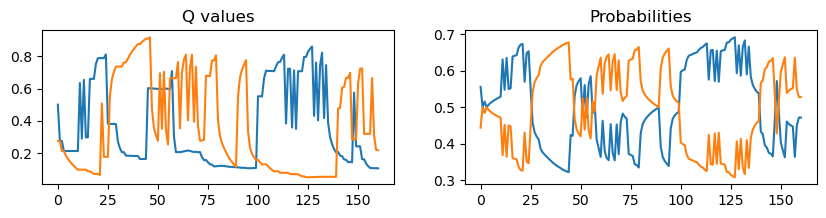

differential_evolution step 1: f(x)= 539.858
differential_evolution step 2: f(x)= 539.858
differential_evolution step 3: f(x)= 537.263
differential_evolution step 4: f(x)= 532.354
differential_evolution step 5: f(x)= 527.02
differential_evolution step 6: f(x)= 527.02
differential_evolution step 7: f(x)= 527.02
differential_evolution step 8: f(x)= 527.02
differential_evolution step 9: f(x)= 518.93
differential_evolution step 10: f(x)= 518.93
differential_evolution step 11: f(x)= 511.139
differential_evolution step 12: f(x)= 511.139
differential_evolution step 13: f(x)= 511.139
differential_evolution step 14: f(x)= 511.139
differential_evolution step 15: f(x)= 511.139
differential_evolution step 16: f(x)= 509.726
differential_evolution step 17: f(x)= 509.726
differential_evolution step 18: f(x)= 509.726
differential_evolution step 19: f(x)= 509.726
differential_evolution step 20: f(x)= 509.726
differential_evolution step 21: f(x)= 509.457
differential_evolution step 22: f(x)= 509.259
dif

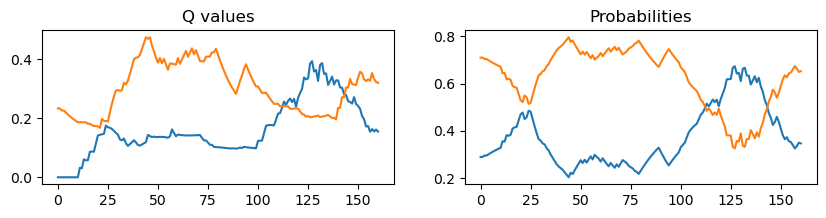

In [9]:
# initialize the class
qlearn = HetQLearning()

# define a guess for the parameters
params_init = [0.5, 0.5, 0.1, 0.8, 15, 1.]
params_bounds = [(0,1), (0,1), (0,1), (0,1), (5,30), (0.01,100)]
qs = qlearn.q_learning(choices_full[0], rewards_full[0], params_init)
ps = qlearn.prob_choice(choices_full[0], rewards_full[0], params_init)

fig,ax = plt.subplots(1,2, figsize=(10,2))
ax[0].plot(qs)
ax[0].set_title('Q values')
ax[1].plot(ps)
ax[1].set_title('Probabilities')
plt.show()

# fit the model to the data
res = qlearn.fit_all(
    choices_full[:5], rewards_full[:5], params_init, lambda_reg=0,
    bounds=params_bounds,
    maxiter=1000, popsize=100, tol=1e-3, disp=True)

# plot the results
qs = qlearn.q_learning(choices_full[0], rewards_full[0], res.x)
ps = qlearn.prob_choice(choices_full[0], rewards_full[0], res.x)

fig,ax = plt.subplots(1,2, figsize=(10,2))
ax[0].plot(qs)
ax[0].set_title('Q values')
ax[1].plot(ps)
ax[1].set_title('Probabilities')
plt.show()


In [12]:
print("Best fit parameters: ", [f"{x:0.5f}" for x in res.x])    

Best fit parameters:  ['0.00000', '0.24097', '0.06422', '0.00077', '6.04254', '0.26004']


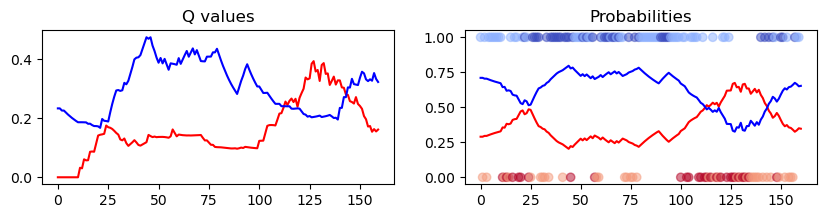

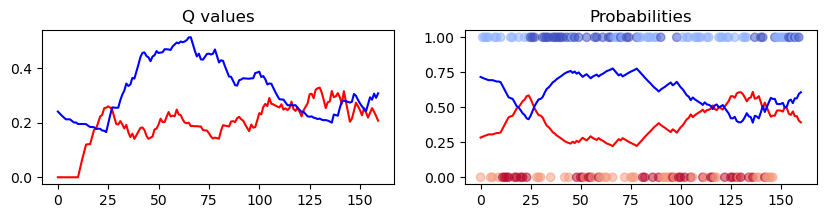

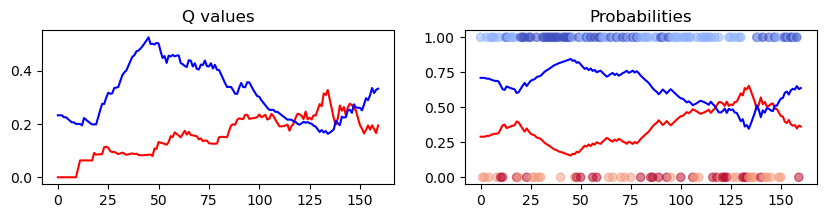

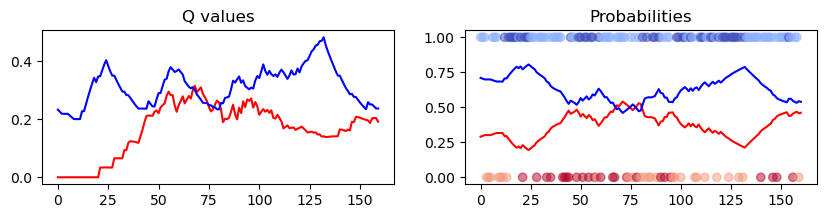

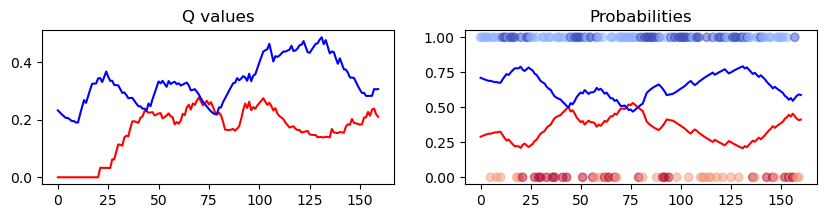

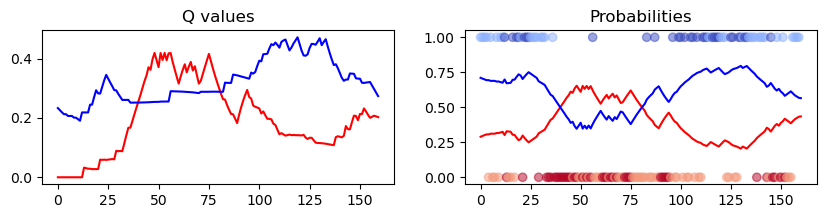

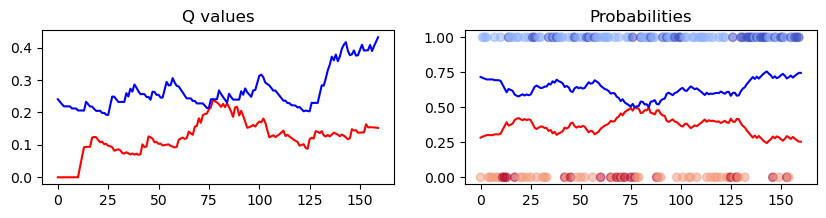

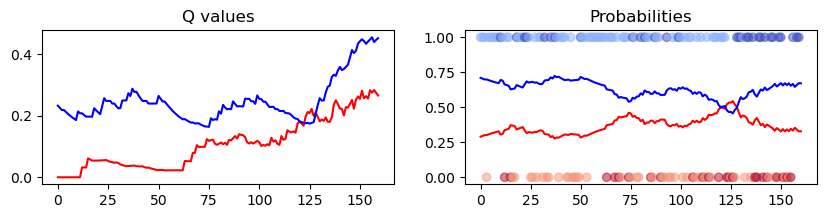

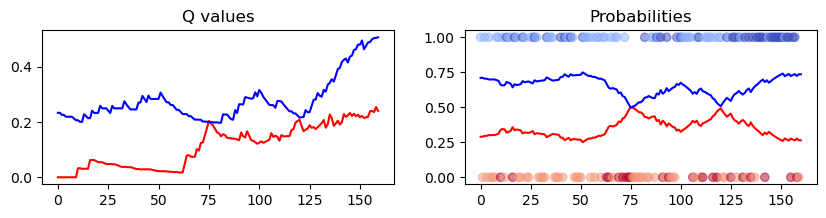

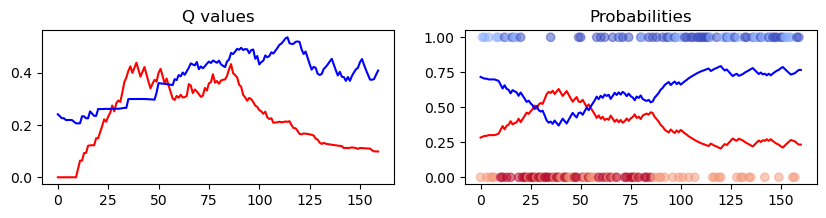

In [10]:
for i in range(10):
    # plot the results
    qs = qlearn.q_learning(choices_full[i], rewards_full[i], res.x)
    ps = qlearn.prob_choice(choices_full[i], rewards_full[i], res.x)

    fig,ax = plt.subplots(1,2, figsize=(10,2))
    ax[0].plot(qs[:-1,0], color='red')
    ax[0].plot(qs[:-1,1], color='blue')
    ax[0].set_title('Q values')
    ax[1].plot(ps[:,0], color='red')
    ax[1].plot(ps[:,1], color='blue')
    c=(((rewards_full[i]+1)*(1-2*choices_full[i]))+2)/4
    ax[1].scatter(np.arange(len(choices_full[i])), choices_full[i], c=plt.cm.coolwarm(c),alpha=0.5)
    ax[1].set_title('Probabilities')
    plt.show()

In [3]:
# initialize the class
qlearn = QLearning()

# define a guess for the parameters
params_init = [0.5, 0.5, 0.05, 1.]

# parallelize the fitting of single subjects
res = Parallel(n_jobs=4)(
    delayed(qlearn.fit_all_except)(
        subject, choices_full, rewards_full, params_init, lambda_reg=0,
        bounds=[(0,1), (0,1), (0,1),(0.01,100)],
        maxiter=1000, popsize=100, tol=1e-3, disp=True
        ) for subject in tqdm(range(132)))


  9%|▉         | 12/132 [17:29<2:49:57, 84.98s/it]

KeyboardInterrupt: 

In [6]:
res = np.loadtxt('qlearn_params_loo.csv', delimiter=',')

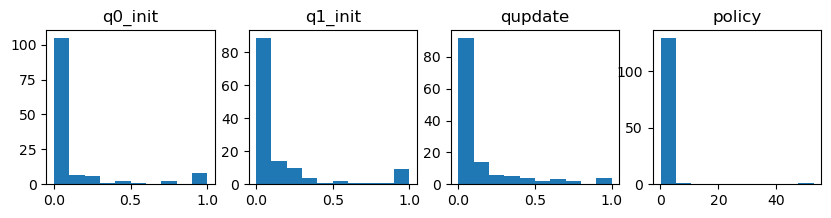

In [7]:
res = np.array(res)

# plot histograms of the parameters
fig,ax = plt.subplots(1,4, figsize=(10,2))
ax[0].hist(res[:,0])
ax[0].set_title('q0_init')
ax[1].hist(res[:,1])
ax[1].set_title('q1_init')
ax[2].hist(res[:,2])
ax[2].set_title('qupdate')
ax[3].hist(res[:,3])
ax[3].set_title('policy')
plt.show()

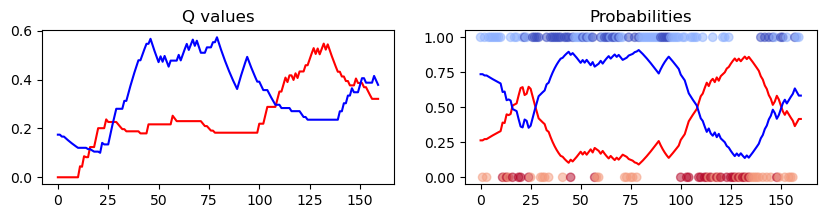

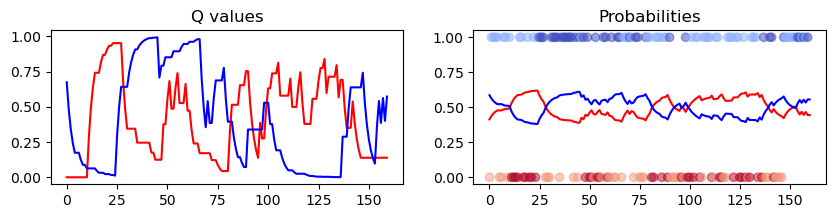

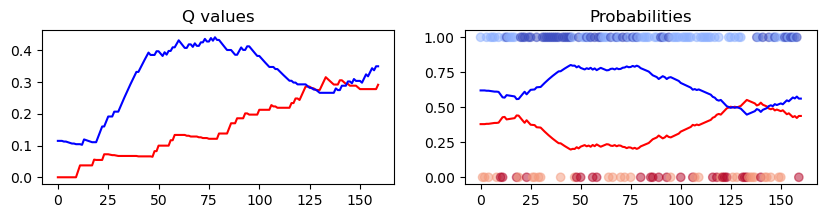

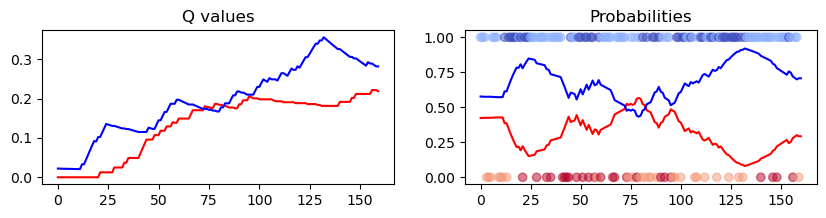

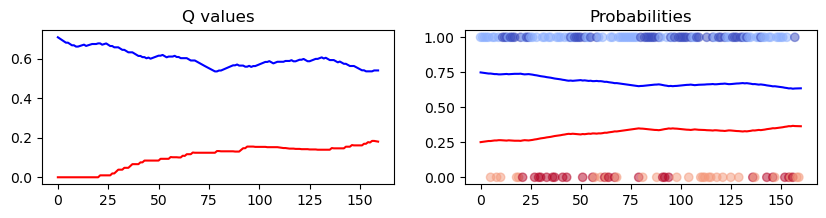

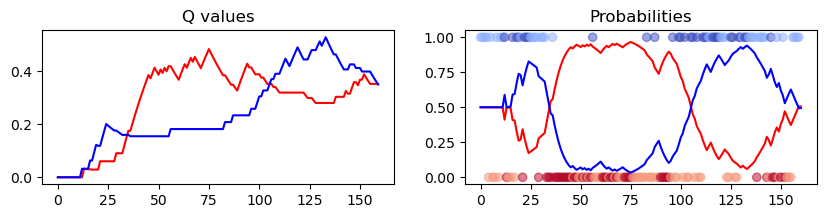

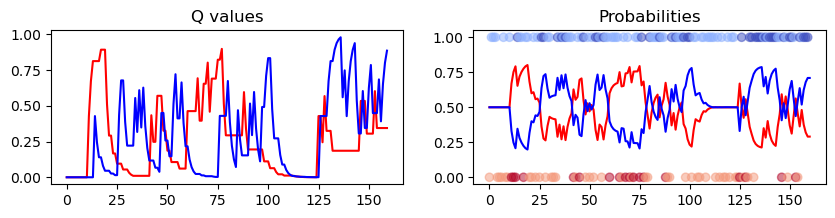

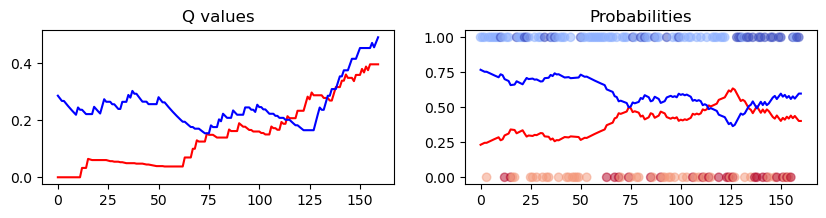

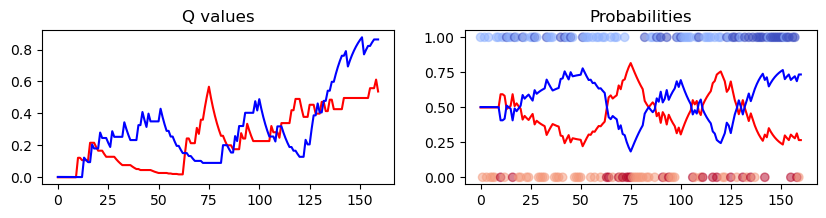

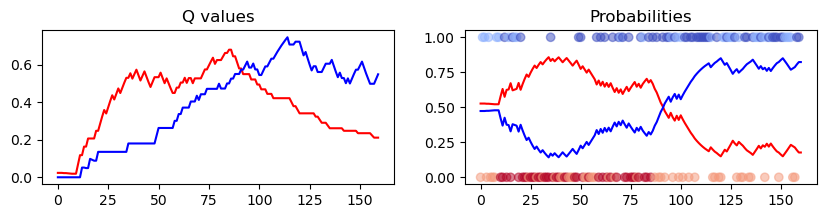

In [15]:
for i in range(10):
    # plot the results
    qs = qlearn.q_learning(choices_full[i], rewards_full[i], res[i])
    ps = qlearn.prob_choice(choices_full[i], rewards_full[i], res[i])

    fig,ax = plt.subplots(1,2, figsize=(10,2))
    ax[0].plot(qs[:-1,0], color='red')
    ax[0].plot(qs[:-1,1], color='blue')
    ax[0].set_title('Q values')
    ax[1].plot(ps[:,0], color='red')
    ax[1].plot(ps[:,1], color='blue')
    c=(((rewards_full[i]+1)*(1-2*choices_full[i]))+2)/4
    ax[1].scatter(np.arange(len(choices_full[i])), choices_full[i], c=plt.cm.coolwarm(c),alpha=0.5)
    ax[1].set_title('Probabilities')
    plt.show()

In [234]:
# optimize the parameters
init_params = np.array([0., 0., 0.05, 1.])

# global optimization using genetic algorithm
res = opt.differential_evolution(
    qlearn.nll_reg,
    bounds=[(0,1), (0,1), (0,1),(0.1,100)], 
    args=(choices_full[:1], rewards_full[:1], 0.1),
    maxiter=1000, popsize=100, tol=1e-3,
    disp=True
    )

print(res.x)

differential_evolution step 1: f(x)= 96.0156
differential_evolution step 2: f(x)= 96.0156
differential_evolution step 3: f(x)= 91.957
differential_evolution step 4: f(x)= 91.957
differential_evolution step 5: f(x)= 91.957
differential_evolution step 6: f(x)= 91.957
differential_evolution step 7: f(x)= 90.7594
differential_evolution step 8: f(x)= 90.7594
differential_evolution step 9: f(x)= 90.7594
differential_evolution step 10: f(x)= 90.7594
differential_evolution step 11: f(x)= 90.7594
differential_evolution step 12: f(x)= 90.6396
differential_evolution step 13: f(x)= 89.0609
differential_evolution step 14: f(x)= 89.0609
differential_evolution step 15: f(x)= 89.0609
differential_evolution step 16: f(x)= 89.0609
differential_evolution step 17: f(x)= 89.0326
differential_evolution step 18: f(x)= 88.6317
differential_evolution step 19: f(x)= 88.6317
differential_evolution step 20: f(x)= 88.6317
differential_evolution step 21: f(x)= 88.6317
differential_evolution step 22: f(x)= 87.9032
d

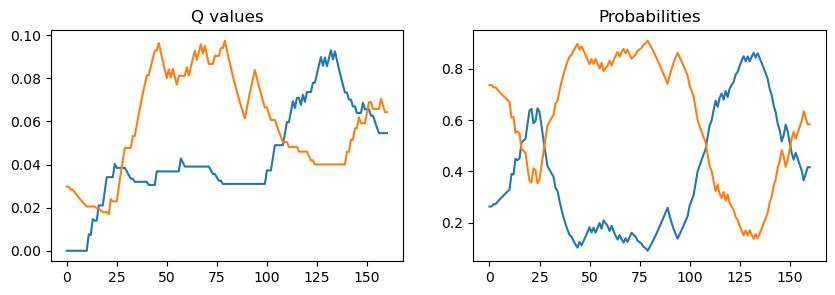

In [235]:
qs = qlearn.q_learning(choices_full[0], rewards_full[0], res.x)
ps = qlearn.prob_choice(choices_full[0], rewards_full[0], res.x)
fig,ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(qs*res.x[-1])
ax[0].set_title('Q values')
ax[1].plot(ps)
ax[1].set_title('Probabilities')
plt.show()

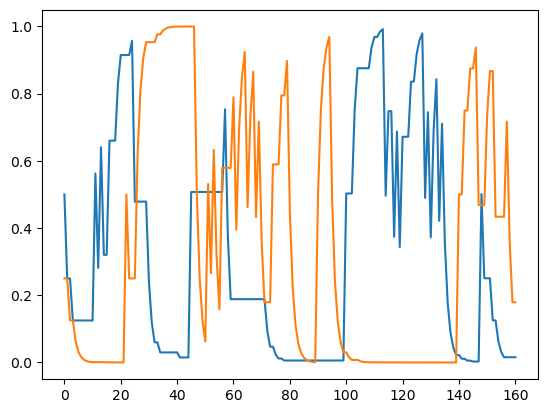

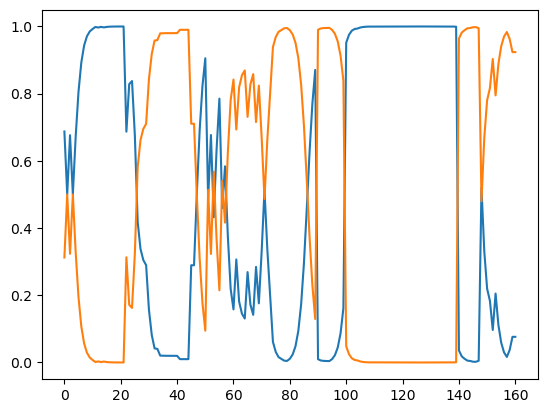

In [50]:
plt.plot(qs)
plt.show()
plt.plot(ps)
plt.show()

In [ ]:
# def ar_policy(q):
#     q = q.T
#     q = np.clip(q, 1e-6, 1-1e-6)
#     p0 = q[0]*(3-q[1])/(3*q[0] + 3*q[1] - 2 * q[0] * q[1])
#     p1 = 1 - p0
#     return np.array([p0, p1]).T

In [ ]:
class HetQLearningB(QLearning):

    # redefine the q learning function
    def q_learning(self, choices, rewards, params):
        # define two sets of q values
        qs_a = np.zeros((len(choices)+1,2))
        qs_b = np.zeros((len(choices)+1,2))
        qs_a[0,:], qs_b[0,:] = params[:2], params[:2]
        for i in range(len(choices)):
            qs_a[i+1,:] = self.q_update(qs_a[i,:],int(choices[i]), rewards[i], params[2:])
            qs_b[i+1,:] = self.q_update(qs_b[i,:],int(choices[i]), rewards[i], params[3:])
        # find likelihood of each set of q values
        ps_a = np.clip(self.policy(qs_a,params), self.eps, 1-self.eps)[:-1,:]
        ps_b = np.clip(self.policy(qs_b,params), self.eps, 1-self.eps)[:-1,:]
        ll_a = choices * np.log(ps_a[:,1]) + (1-choices) * np.log(ps_a[:,0])
        ll_b = choices * np.log(ps_b[:,1]) + (1-choices) * np.log(ps_b[:,0])
        # mix the q values weighted by past likelihood
        tau = params[-2]
        kernel = np.exp(np.arange(len(choices))/ tau)
        cutoff_idx = np.where(kernel < 0.1)[0][0] if len(np.where(kernel < 0.1)[0]) > 0 else len(kernel)
        kernel = kernel[:cutoff_idx][::-1]
        kernel = kernel / np.sum(kernel)
        # convolve the kernel with the likelihoods
        ll_a = np.convolve(ll_a, kernel, mode='full')[:len(choices)]
        ll_b = np.convolve(ll_b, kernel, mode='full')[:len(choices)]
        # calculate relative weights
        w = np.exp(ll_a) / (np.exp(ll_a) + np.exp(ll_b))
        plt.plot(w)
        plt.show()
        # mix the q values
        qs = (qs_a + qs_b)/2
        qs[1:,:] = qs_a[1:,:] * w[:,None] + qs_b[1:,:] * (1-w[:,None])
        return qs
    
    # redefine the parameter properties
    def param_props(self):
        param_props = {
            'names': ['q0_init', 'q1_init'] + ['alpha_%i' % i for i in range(2)] + ['tau', 'beta'],
            'suggested_bounds': [(0,1),(0,1)] + [(0,1) for i in range(2)] + [(1,30), (0.01,100)],
            'n_q': 1, # number of q update parameters per module
            'n_p': 2 # number of policy parameters
            }
        return param_props

qlearn = HetQLearningB()

params_bounds = qlearn.param_props()['suggested_bounds']
params_init = [0.5, 0.5, 0.1, 0.8, 15, 1.]

qs = qlearn.q_learning(choices_full[0], rewards_full[0], params_init)
ps = qlearn.prob_choice(choices_full[0], rewards_full[0], params_init)

fig,ax = plt.subplots(1,2, figsize=(10,2))
ax[0].plot(qs)
ax[0].set_title('Q values')
ax[1].plot(ps)
ax[1].set_title('Probabilities')
plt.show()